In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def import_data():
    raw_data_df = pd.read_csv("LCL-June2015v2_1.csv", header=0)
    return raw_data_df

In [3]:
result = import_data()
result.head()
# result.columns

,LCLid,stdorToU,DateTime,KWH/hh (per half hour)
0,MAC000036,Std,2012-11-08 10:30:00.0000000,0.003
1,MAC000036,Std,2012-11-08 11:00:00.0000000,0.032
2,MAC000036,Std,2012-11-08 11:30:00.0000000,0.035
3,MAC000036,Std,2012-11-08 12:00:00.0000000,0
4,MAC000036,Std,2012-11-08 12:30:00.0000000,0


In [4]:
result['date'] = pd.to_datetime(result['DateTime'])
result.head(3)


,LCLid,stdorToU,DateTime,KWH/hh (per half hour),date
0,MAC000036,Std,2012-11-08 10:30:00.0000000,0.003,2012-11-08 10:30:00
1,MAC000036,Std,2012-11-08 11:00:00.0000000,0.032,2012-11-08 11:00:00
2,MAC000036,Std,2012-11-08 11:30:00.0000000,0.035,2012-11-08 11:30:00


In [5]:
data = result.loc[:,['KWH/hh (per half hour) ']]
data = data.set_index(result.date)
data['KWH/hh (per half hour) '] = pd.to_numeric(data['KWH/hh (per half hour) '], downcast='float', errors='coerce')
data.head()

,KWH/hh (per half hour)
date,
2012-11-08 10:30:00,0.003
2012-11-08 11:00:00,0.032
2012-11-08 11:30:00,0.035
2012-11-08 12:00:00,0.000
2012-11-08 12:30:00,0.000


<Axes: xlabel='date'>

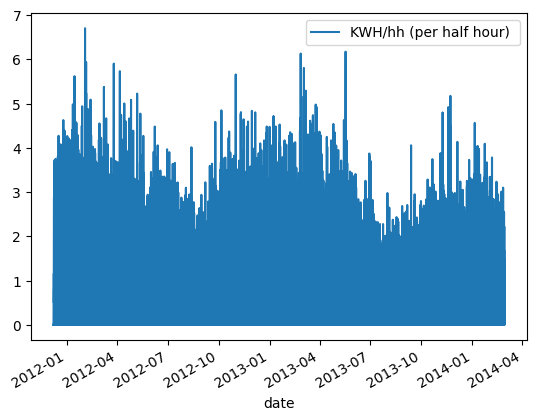

In [6]:
data.plot()

<Axes: xlabel='date'>

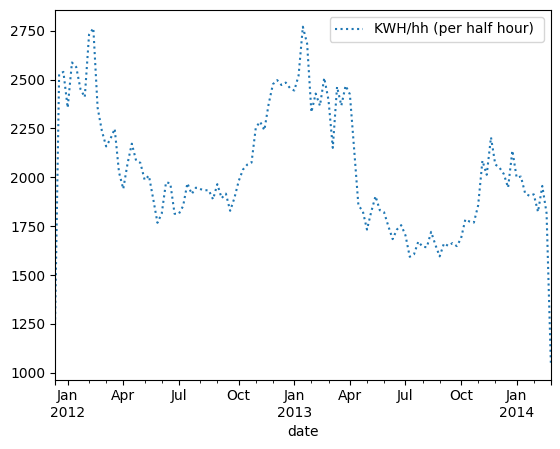

In [7]:
weekly = data.resample('W').sum()
weekly.plot(style = [':', '--', '-'])

<Axes: xlabel='date'>

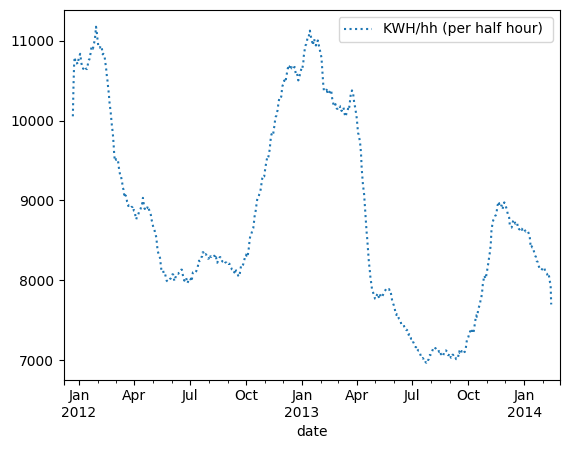

In [8]:
daily = data.resample('D').sum()
daily.rolling(30, center=True).sum().plot(style = [':', '--', '-'])

<Axes: xlabel='time'>

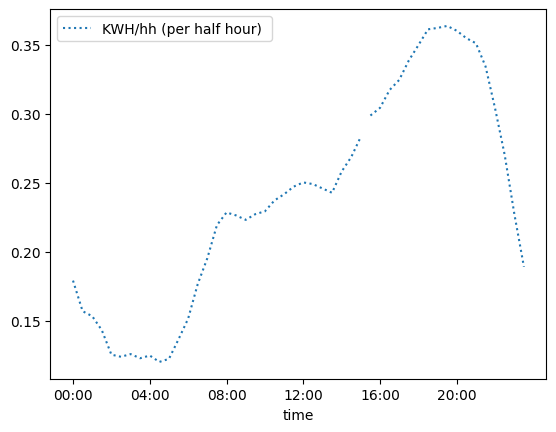

In [9]:
by_time = data.groupby(data.index.time).mean()
hourly_ticks = 4 * 60 * 60 * np.arange(6)
by_time.plot(xticks=hourly_ticks, style = [':', '--', '-'])

<Axes: xlabel='date'>

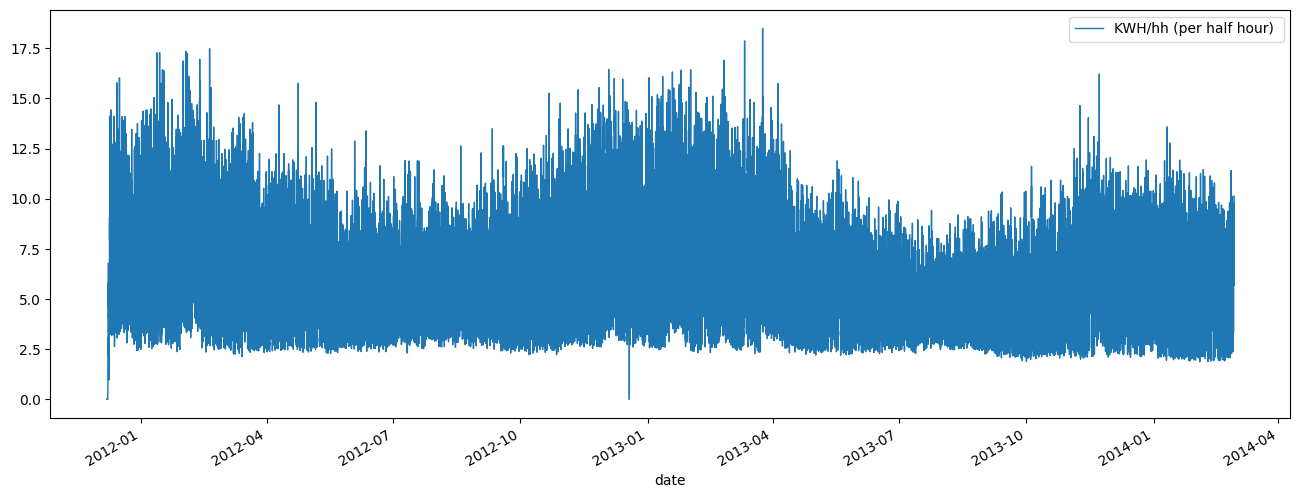

In [10]:
df = result.loc[:, ['date', 'KWH/hh (per half hour) ']]
df['KWH/hh (per half hour) '] = pd.to_numeric(df['KWH/hh (per half hour) '], errors='coerce')
df = df.groupby(['date']).sum().reset_index()
df.head()

df.plot.line(x = 'date', y = 'KWH/hh (per half hour) ', figsize=(16,6), linewidth=1, fontsize=10)

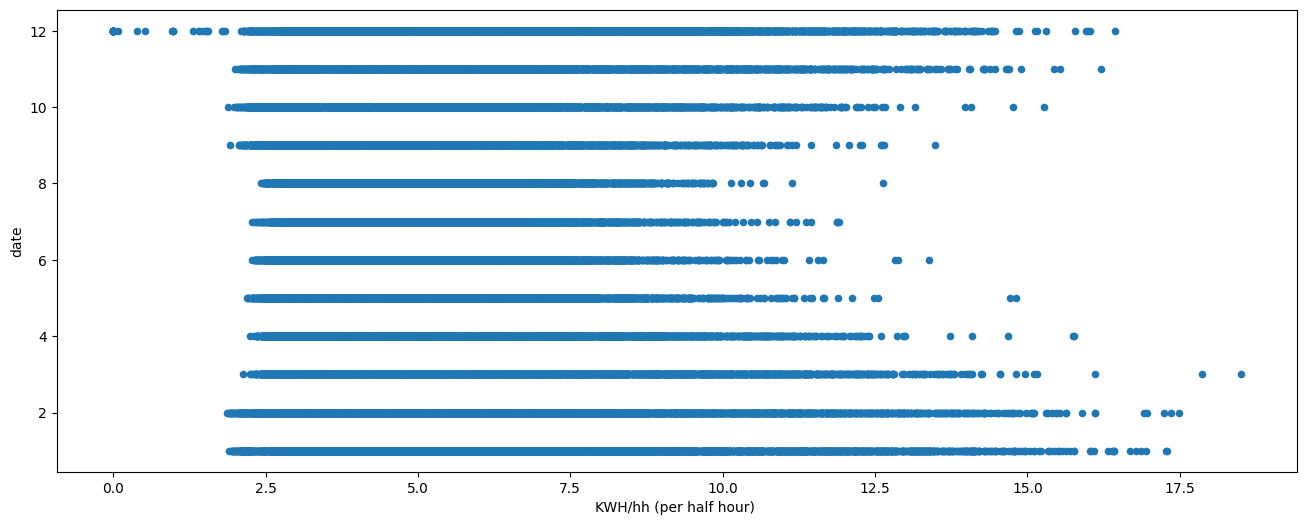

In [11]:
mon = df['date']
temp = pd.DatetimeIndex(mon)
month = pd.Series(temp.month)
to_be_plotted = df.drop(['date'], axis = 1)
to_be_plotted = to_be_plotted.join(month)

to_be_plotted.plot.scatter(x = 'KWH/hh (per half hour) ', y = 'date', figsize = (16,6), linewidth=1, fontsize=10)
plt.show()

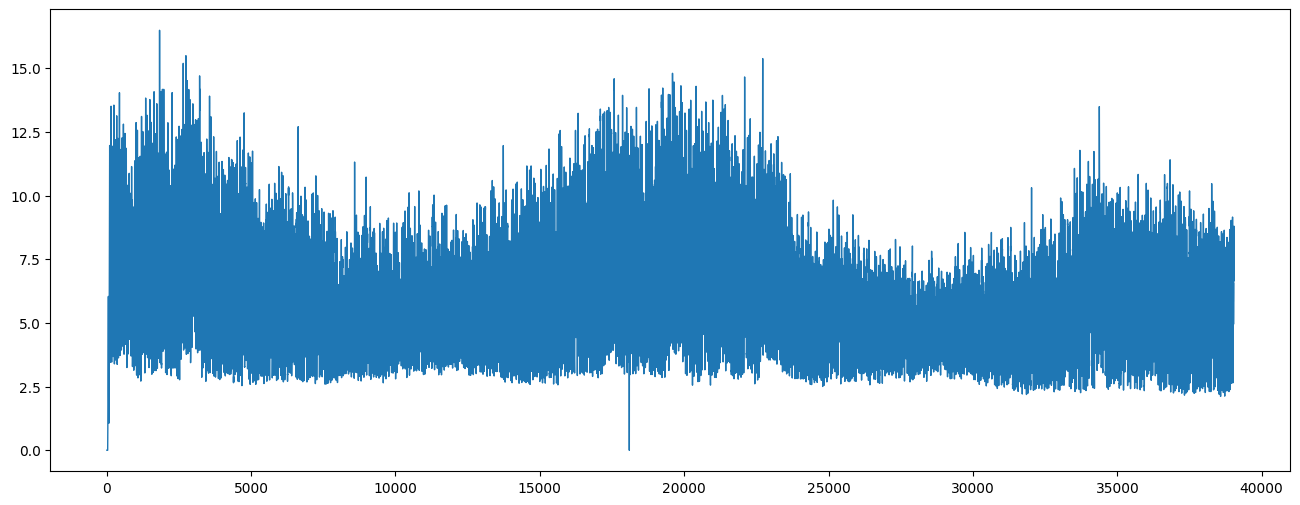

In [12]:
# for trend analysis
df['KWH/hh (per half hour) '].rolling(5).mean().plot(figsize = (16,6), linewidth=1, fontsize=10)
plt.show()

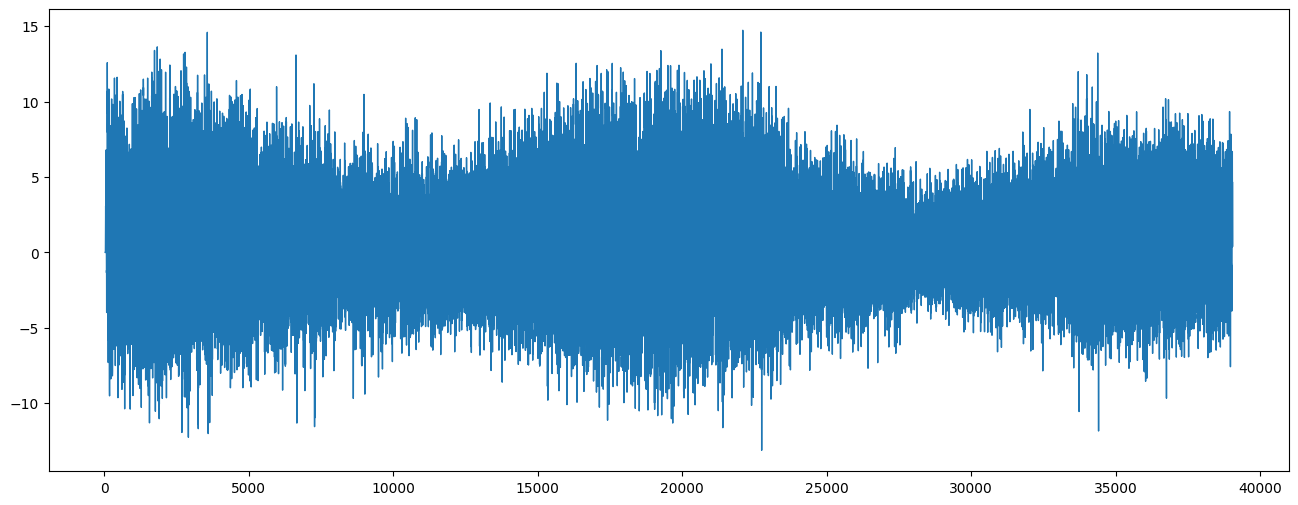

In [13]:
# for seasonal variation
df['KWH/hh (per half hour) '].diff(periods=30).plot(figsize = (16,6), linewidth=1, fontsize=10)
plt.show()


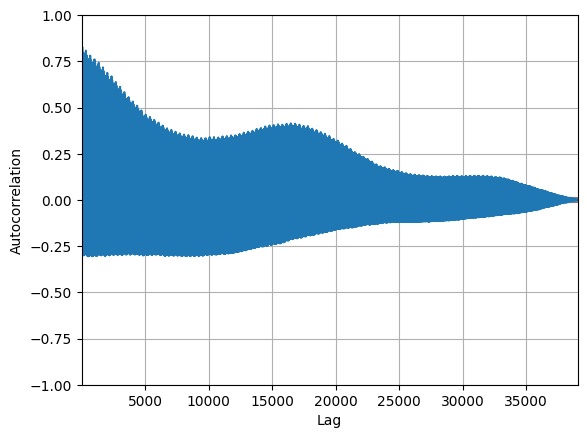

In [14]:
pd.plotting.autocorrelation_plot(df['KWH/hh (per half hour) '])
plt.show()

# 4. Modeling with Prophet
Facebook Prophet, released in 2017 for Python and R, is a time series analysis tool. It excels at handling daily observations with patterns on various time scales, tolerates missing data and trend shifts, and effectively handles outliers. Prophet also offers advanced features for modeling holiday effects and implementing custom changepoints. However, for simplicity, I'll focus on the basics to quickly set up a model. Prophet is a suitable choice for producing rapid forecasts due to its intuitive parameters, making it accessible to domain experts with less forecasting model expertise. 

In [15]:
df2 = daily
df2.reset_index(inplace=True)

# Prophet requires columns ds as Date and y as value
df2 = df2.rename(columns={'date': 'ds', 'KWH/hh (per half hour) ': 'y'})

df2.head()

,ds,y
0,2011-12-07,0.014000
1,2011-12-08,117.203003
2,2011-12-09,286.204987
3,2011-12-10,391.217010
4,2011-12-11,393.061005


22:41:05 - cmdstanpy - INFO - Chain [1] start processing
22:41:05 - cmdstanpy - INFO - Chain [1] done processing


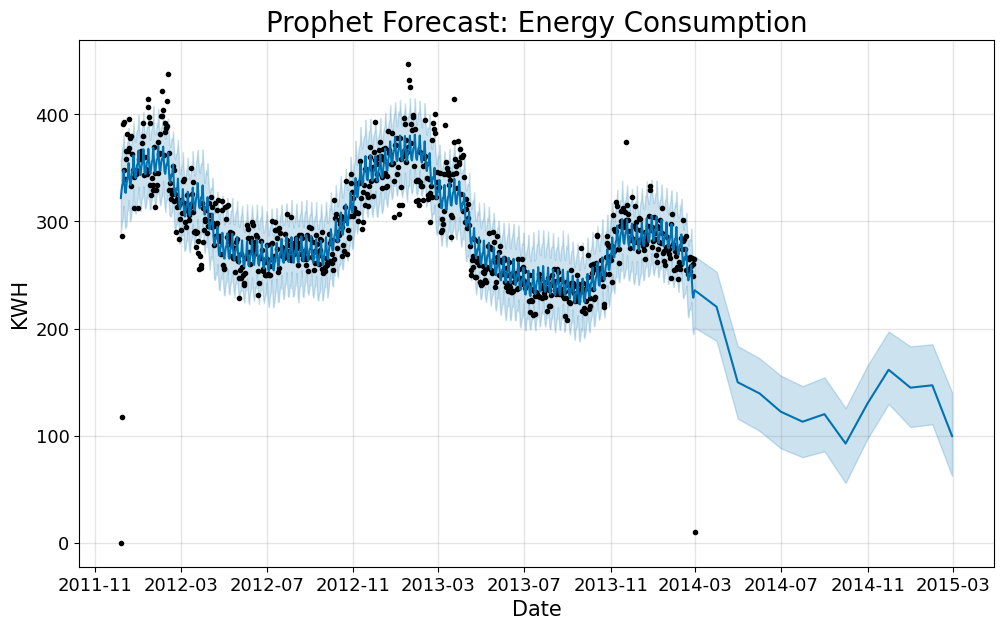

In [35]:
# Import necessary packages
import matplotlib.pyplot as plt
from prophet import Prophet

# Initialize a Prophet object with a specified hyperparameter
pp_model = Prophet(changepoint_prior_scale=0.1)

# Fit the model to the data
pp_model.fit(df2)

# Create a future dataframe for 12 months
pp_future = pp_model.make_future_dataframe(periods=12, freq='M')

# Make predictions
pp_forecast = pp_model.predict(pp_future)

# Plot the predictions
pp_model.plot(pp_forecast, xlabel = 'Date', ylabel = 'KWH')
plt.title('Prophet Forecast: Energy Consumption', fontsize = 20)
plt.xlabel('Date', fontsize=15)
plt.ylabel('KWH', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

# Display the plot
plt.show()


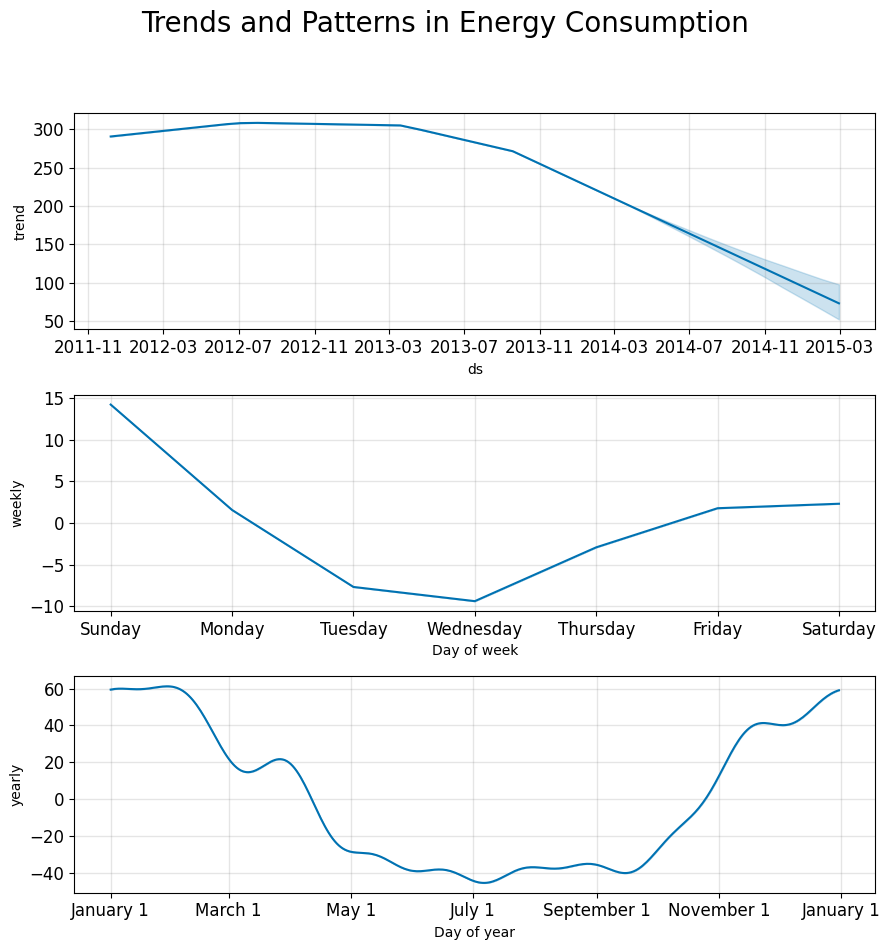

In [39]:
# Plot the components of the forecast
fig = pp_model.plot_components(pp_forecast)

# Add a super title to the figure
fig.suptitle('Trends and Patterns in Energy Consumption', fontsize=20, y=1.05)

# Improve plot aesthetics
for ax in fig.axes:
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    
# Adjust the layout
plt.tight_layout()

# Display the plots
plt.show()


The annual pattern of household energy consumption notably rises during fall and winter, while dipping in spring and summer, as anticipated. A weekly analysis reveals higher consumption on Sundays. Over time, the trend shows a year-long decrease in consumption from 2013. Future exploration will aim to elucidate this trend and determine possible correlations with weather patterns.